# A proof of concept for the article [SEcure Similar Image Matching (SESIM): An Improved Privacy Preserving Image Retrieval Protocol over Encrypted Cloud Database](https://ieeexplore.ieee.org/document/9522057)



Where the authors propose an image retrevial protocol such that the extracted features in the database reamin encrypted, and the extracted features from the query image are encrypted.
For the discussion and evaluation of proposed method against conventional methods section the paper used the [INRIA Holidays Dataset](https://www.kaggle.com/datasets/rasvanjaya21/inria-holidays-dataset/) for the analysis.


The notebook will be divided into two sections :

1. Plaintext similarity with a high level feature extractor(VGG-16):using  accuracy,precision,recall and FPR (False Positive Rate) metrics.

2. Encrypted similarity: using the same metrics as above for high level features

3. Plaintext similarity with a low level feature extractor(HOG):using  accuracy,precision,recall and FPR (False Positive Rate) metrics.

4. Encrypted similarity: using the same metrics as above for low level features

5. Mutiparty|


## Section 1 : Plaintext similarity

This section will do the following :
1. Downloading the data from kaggle
2. Convert it into a `PyTorch` dataset. Use the VGG-16 model (the same one used in the paper) from `tochvision.models`
3. Extract the image features from the dataset
4. Test the images using the query image
5. Calculate the above mentioned metrics  




### 1.1 Downloading the data
1. Get API Key from Kaggle
2. Upload the API key to colab then move to `~/.kaggle/` and change the premisssions
3. Use `!kaggle datasets download` command to download the data
4. Unzip the data   


In [ ]:
from pathlib import Path
data_path=Path.cwd()
new_pth = data_path/"holiday"
if new_pth.exists():
    print("Data is already downloaded")

else :
    from google.colab import files
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !rm -rf kaggle.json
    !kaggle datasets download -d rasvanjaya21/inria-holidays-dataset
    !unzip inria-holidays-dataset.zip -d holiday
    !rm -rf inria-holidays-dataset.zip

### 1.2 Converting the data to PyTorch data

1. Explore the data using `os.walk()` just to get the number of classes and the number of images in each class
2. Visualize some random images
3. Load the model weights and the model from `torchvision.models`
4. Get the preprocessor that is used in VGG-16 by calling `wights.transforms()`
5. Load the data using `torchvision.datasets.LoadImage`
6. Convert the data into batches by calling

In [ ]:
import torchvision
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
try:
    import torchmetrics
    from torchsummary import summary

except ModuleNotFoundError :
    !pip install torchmetrics
    !pip install torch-summary
    import torchmetrics
    from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
data_dir="content"


In [ ]:
for root,dirs,files in os.walk("/content/holiday/"):
    print(f"Found {root} ,Containng {len(files)}")

Found /content/holiday/ ,Containng 0
Found /content/holiday/lukisan ,Containng 10
Found /content/holiday/piramida ,Containng 10
Found /content/holiday/sampan ,Containng 10
Found /content/holiday/rumah ,Containng 10
Found /content/holiday/kuil ,Containng 10
Found /content/holiday/taman ,Containng 10
Found /content/holiday/pelabuhan ,Containng 10
Found /content/holiday/kerucut ,Containng 10
Found /content/holiday/gunung ,Containng 10
Found /content/holiday/laguna ,Containng 10
Found /content/holiday/terumbu ,Containng 10
Found /content/holiday/pemukiman ,Containng 10
Found /content/holiday/venice ,Containng 10
Found /content/holiday/bunga ,Containng 10
Found /content/holiday/sunset ,Containng 10
Found /content/holiday/lembah ,Containng 10
Found /content/holiday/fajar ,Containng 10
Found /content/holiday/perahu ,Containng 10
Found /content/holiday/buah ,Containng 10
Found /content/holiday/petra ,Containng 10


**Note:** the sample data contains ten classes and each class has ten images

In [ ]:
from pathlib import Path
data_path=Path.cwd()
new_pth = data_path/"holiday"
imgs_lst= list(new_pth.glob("*/*.jpg"))
len(imgs_lst) # To check if all the images are in jpg format

200

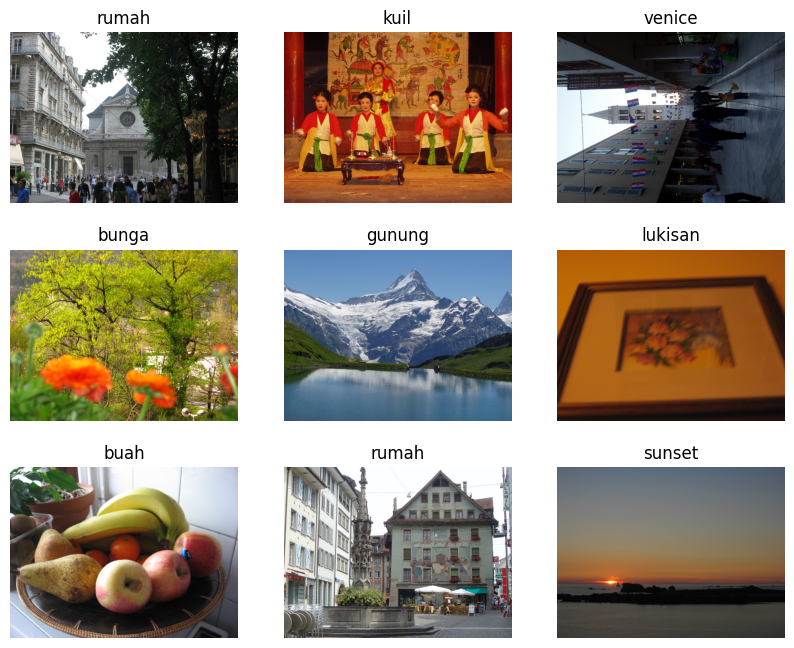

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,8))

for i in range(1,10):
    idx = np.random.randint(len(imgs_lst))
    image_path = imgs_lst[idx]
    image_label =  str(image_path).split("/")[-2]
    im = Image.open(image_path)
    im_array=np.array(im)
    plt.subplot(3,3,i)
    plt.imshow(im_array)
    plt.title(image_label)
    plt.grid(False)
    plt.axis("off")




In [ ]:
from torchvision.models import vgg16_bn,VGG16_BN_Weights
weights = VGG16_BN_Weights.DEFAULT
preprocessor = weights.transforms()
model = vgg16_bn(weights=weights).to(device)
summary(model,torch.rand(1,3,224,224),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        128
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       256
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 112, 112]      

### 1.3 Feature extraction

In [ ]:
# Freezing the layers of the model
for param in model.parameters():
    param.requires_grad=False

model.classifier = nn.Sequential(*[model.classifier[i] for i in range(4)])
print(model.classifier)
summary(model,torch.rand(1,3,224,224),device=device)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        (36,928)
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (73,856)
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       (25

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        (36,928)
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (73,856)
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       (256)
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       (147,584)
|    └─BatchNorm2d: 2-12                 [-1, 128, 1

Loading the data

In [ ]:
data = datasets.ImageFolder(root=new_pth,
                            transform=preprocessor)
data_classes= data.classes
class_to_idx= data.class_to_idx

In [ ]:
BATCH_SIZE=40#@param{type:"slider",min:0,max:128,step:4}
torch_dataset = DataLoader(data,batch_size=BATCH_SIZE)

In [ ]:
model.eval()
features=[]
classes=[]
with torch.inference_mode():
    for X,y in torch_dataset:
        X,y=X.to(device),y.to(device)
        features_batch= model(X).squeeze()
        classes.append(y)
        features.append(features_batch)
    features=torch.cat(features,0)
    classes=torch.cat(classes,0)

### 1.4 Testing

For testing firstly a dataframe will be set up conting the image features, the class idx and the name of the class.

Testing will follow the following procedure:
for every image in the dataframe do the follwoing:
* Set every same class as the image to 1 the others to 0 (ground truth)

* Calculate the distance between the image and every feature if the distanc is within a threshold set this to true

* Calculate the metrics for every distance mmeasure then plot and compare

**Note:** the distance measures that will be used are :
1. Eculidan distance  
2. Manhattan distance
3. Jaccard distance
4. Cosine similarity

In [ ]:
classes.shape

torch.Size([200])

In [ ]:
features.shape

torch.Size([200, 4096])

In [ ]:
import pandas as pd
# Moving the data back to the CPU since pandas,numpy and matplotlib can't work with the GPU
if device =="cuda":
    classes=classes.cpu().numpy()
    features=features.cpu().numpy()
else:
    classes=classes.numpy()
    features=features.numpy()
class_names = [data_classes[int(class_idx)] for class_idx in classes]
pd_data= {"Name":class_names,
          "idx":classes,
          "features":features.tolist()}
df = pd.DataFrame(data=pd_data)
df.head()


,Name,idx,features
0,buah,0,"[-0.764498233795166, 0.2703744173049927, -0.57..."
1,buah,0,"[-0.7869440913200378, -0.14904724061489105, -1..."
2,buah,0,"[-0.6767528057098389, 0.3972959518432617, -1.1..."
3,buah,0,"[-0.3759235143661499, 0.4669526219367981, -1.3..."
4,buah,0,"[-1.0289041996002197, 0.1245494931936264, -1.1..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      200 non-null    object
 1   idx       200 non-null    int64 
 2   features  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [ ]:
#Set to True if you want to save the results to google drive
save = False # @param {type:"boolean"}
if save:
    df.to_csv("inira_holiday.csv",index=False)
    from google.colab import drive
    drive.mount('/content/drive')
    !cp /content/inira_holiday.csv /content/drive/MyDrive/

In [ ]:
completing_session = True# @param{type:"boolean"}
if completing_session:
    import ast
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv("/content/drive/MyDrive/inira_holiday_encrypted.csv",usecols=["idx","features"],
                     converters={'features': ast.literal_eval,})

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from typing import Dict
from timeit import default_timer
def eculidan_distance(query_features:np.ndarray,feature_vectors:np.ndarray,
                      threshold:float=1.1,normalize=True)->np.ndarray:
    """
    Calculates the eculidan distances between a vector and the stored feature vectors
     i.e the following forumla : sum(abs(x-y)**2)**(1./2)

    Args:
        query_features: a numpy array for the extracted features from the image shape(x)
        where x is the number of features the feature extractor outputs
        feature_vectors: a numpy array which for the features of the stored images shape(n,x) where
        n is the number of images stored and x is the number of features the the feature extractor outputs
        threshold (optional): float a number to check for
        normalize (optional): boolean whether to normalize the vectors

    Returns:
        a boolean numpy array where True indicates that the images are similar and False indicates they're not
        according to the given threshold
    """
    if normalize:
        query_features/=np.linalg.norm(query_features)
        feature_vectors/=np.linalg.norm(feature_vectors,axis=1,keepdims=True)
    return np.linalg.norm(query_features-feature_vectors,axis=1)<threshold

def manhattan_distance(query_features:np.ndarray,feature_vectors:np.ndarray,
                       threshold:float=55,normalize=True)->np.ndarray:
    """
    Calculates the Manhattan distance between a vector and the stored feature vectors
    i.e the following forumla : sum(abs(x-y))
    Args:
        query_features: a numpy array for the extracted features from the image shape(x)
        where x is the number of features the feature extractor outputs
        feature_vectors: a numpy array which for the features of the stored images shape(n,x) where
        n is the number of images stored and x is the number of features the the feature extractor outputs
        threshold (optional): float a number to check for
        normalize (optional): boolean whether to normalize the vectors

    Returns:
        a boolean numpy array where True indicates that the images are similar and False indicates they're not
        according to the given threshold
    """
    if normalize:
        query_features/=np.linalg.norm(query_features)
        feature_vectors/=np.linalg.norm(feature_vectors,axis=1,keepdims=True)


    return np.linalg.norm(query_features-feature_vectors,ord=1,axis=1)<threshold


def cos_sim(query_features:np.ndarray,feature_vectors:np.ndarray,threshold=0.45)->np.ndarray:
    """
    Calculates the cosine similarity between two vectors

    Args:
        query_features: a numpy array for the extracted features from the image shape(x)
        where x is the number of features the feature extractor outputs
        feature_vectors: a numpy array which for the features of the stored images shape(n,x) where
        n is the number of images stored and x is the number of features the the feature extractor outputs
        threshold (optional): float a number to check for


    Returns:
        a numpy array of shape n: whther the query image is 'close' to feature vector

    """
    return np.dot(feature_vectors, query_features) / (np.linalg.norm(feature_vectors, axis=1) * np.linalg.norm(query_features))>threshold

def jacard_distance(query_features:np.ndarray,feature_vectors:np.ndarray,threshold=0.2)->np.ndarray:
    """
    Calculates the Jacard distance between two vectors

    Args:
        query_features: a numpy array for the extracted features from the image shape(x)
        where x is the number of features the feature extractor outputs
        feature_vectors: a numpy array which for the features of the stored images shape(n,x) where
        n is the number of images stored and x is the number of features the the feature extractor outputs
        threshold (optional): float a number to check for

    Returns:
        a numpy array of shape n: whther the query image is 'close' to feature vector
    """
    return np.dot(feature_vectors, query_features) / (np.sum(feature_vectors**2,axis=1) + np.sum(query_features**2) - np.dot(feature_vectors, query_features))>threshold


def calculate_metrics(score:np.ndarray,ground_truth:np.ndarray)->(float,float,float,float):
    """
    Calculates Accuracy,precision,Recall and FPR(false positive rate)
    by calculating the true positve(TP),true negative(TN),false positive (FP) and false negative(FG)
    where :
        tp=np.sum(np.logical_and(score == True, ground_truth == True))
        tn=np.sum(np.logical_and(score == False, ground_truth == False))
        fp=np.sum(np.logical_and(score == True, ground_truth == False))
        fn=np.sum(np.logical_and(score == False, ground_truth ==True))
    then accuracy and FPR would be calculated as:
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        fpr = (fp)/(fp+tn)
    then the set of retreived images and the set of similar images(actual similar images)
    would be calculated as follows :
        similar_images=set(np.in1d(ground_truth,True).nonzero()[0].tolist())
        retreived_images=set(np.in1d(score,True).nonzero()[0].tolist())
    then the precision and recall can be calculated as follows:
        precision=len(similar_images.intersection(retreived_images))/len(similar_images)
        recall=len(similar_images.intersection(retreived_images))/len(retreived_images)
    Args:
        score: a numpy array the prediction vector where True indicates that the image is similar to the query image
        ground_truth: a numpy array where True indicates that the images ARE similar
    Returns:
        accuracy,false positive rate,precision,recall
    """
    tp=np.sum(np.logical_and(score == True, ground_truth == True))
    tn=np.sum(np.logical_and(score == False, ground_truth == False))
    fp=np.sum(np.logical_and(score == True, ground_truth == False))
    fn=np.sum(np.logical_and(score == False, ground_truth ==True))
    similar_images=set(np.in1d(ground_truth,True).nonzero()[0].tolist())
    retreived_images=set(np.in1d(score,True).nonzero()[0].tolist())


    accuracy = (tp+tn)/(tp+tn+fp+fn)
    fpr = (fp)/(fp+tn)
    precision=len(similar_images.intersection(retreived_images))/len(similar_images)
    if len(retreived_images)==0:
        recall=0
    else:
        recall=len(similar_images.intersection(retreived_images))/len(retreived_images)

    return accuracy,fpr,precision,recall

from typing import Dict

def calculate_sim_one(df:pd.DataFrame,col:str,
                      measure: str = "euclidean",
                      threshold=None,normalize=True) -> (Dict[str, float],Dict[str, float]):
    """
    Calculates the metrics based on the given similarity measures for the
    following measures (euclidean, manhattan, cosine, jaccard).

    Args:
        df: A pandas DataFrame  filled with extracted features
        to calculate the similarity of and idx to consider as a label
        col: either features or encrypted
        measure: The similarity measure to use ('euclidean', 'manhattan', 'cosine', 'jaccard').
        threshold: Optional threshold for the comparison.
        normalize (optional) whether to normalize the vectors when calling manhattan and euclidean

    Returns:
        Two dictionaries one containing accuracy, false positive rate, precision, and recall.
        the other containing the average time and the total time spent on retrevial
    """


    # Calculate the score based on the selected measure
    if measure == "euclidean":
        threshold = 1.1 if threshold is None else threshold
        fn = eculidan_distance
    elif measure == "manhattan":
        threshold = 55 if threshold is None else threshold
        fn = manhattan_distance
    elif measure == "cosine":
        threshold = 0.5 if threshold is None else threshold
        fn= cos_sim
    elif measure == "jaccard":
        threshold = 0.2 if threshold is None else threshold
        fn = jacard_distance
    else:
        raise ValueError(f"Invalid similarity measure. {measure} Choose from 'euclidean', 'manhattan', 'cosine', 'jaccard'.")
    acc_lst=[]
    fpr_lst=[]
    precision_lst=[]
    recall_lst=[]
    time=[]
    feature_vectors=np.asarray([np.asarray(feature) for feature in df[col]])# The stored feature vectors

    for i,feature in enumerate(feature_vectors):
        ground_truth=np.array(df["idx"]==df.loc[i]["idx"])
        tic=default_timer()
        if measure in ["eulidean","manhattan"]:
            score = fn(np.asarray(feature),feature_vectors,threshold,normalize)
        else:
            score = fn(np.asarray(feature),feature_vectors,threshold)
        tac=default_timer()
        time.append(tac-tic)
        # Calculate metrics
        acc, fpr, precision, recall = calculate_metrics(score, ground_truth)
        acc_lst.append(acc)
        fpr_lst.append(fpr)
        precision_lst.append(precision)
        recall_lst.append(recall)

    time_metrics={"Total time in minutes":np.sum(np.asarray(time))/60,
                  "Average time":np.mean(np.asarray(time))}
    # Return the metrics as a dictionary
    metrics = {"accuracy": np.mean(np.asarray(acc_lst)),
               "FPR": np.mean(np.asarray(fpr_lst)),
               "precision": np.mean(np.asarray(precision_lst)),
                "recall": np.mean(np.asarray(recall_lst))}


    return metrics,time_metrics



def calculate_sim_measures(df:pd.DataFrame,col:str="features"
                            ,euc_threshold:float=1.1,man_threshold:float=55,
                           cos_threshold=0.5,jac_threshold=0.2,normalize=True)->pd.DataFrame:
    """
    Calculates the metrics of the similarity measures according to the distance
    measures and returns their results in a dataframe

    Args:
        df: a pandas data frame containg a column filled with extracted features
        to calculate the similarity of and idx to consider as a label
        col: either features or encrypted
        euc_threshold (optional) a threshold for comparison when calling euclidan_distance
        man_threshold (optional) a threshold for comparison when calling manhattan_distance
        jac_threshold (optional) a threshold for comparison when calling jac_distance
        cos_threshold (optional) a threshold for comparison when calling cos_distance
        normalilze (optional) whether to normalize the vectors when calling euclidan_distance and manhattan_distance


    Returns:
        df: a pnadas DataFrame where the columns are the name of the distance measure
        and the rows are named after the metrics for example:
                        Eculidan|Manhattan|Cosine|Jacard
            accuracy      0.88      0.88   0.88  0.88
            FPR           0.4       0.4   0.4  0.4
            precision     0.3       0.3     0.3    0.3
            recal         0.2       0.2     0.2    0.2

    """
    euc_acc=[]
    euc_recall=[]
    euc_precision=[]
    euc_fpr=[]
    man_acc=[]
    man_recall=[]
    man_precision=[]
    man_fpr=[]
    cos_acc=[]
    cos_recall=[]
    cos_precision=[]
    cos_fpr=[]
    jac_acc=[]
    jac_recall=[]
    jac_precision=[]
    jac_fpr=[]


    feature_vectors=np.asarray([np.asarray(feature) for feature in df[col]])# The stored feature vectors


    for j in range(len(df)):
        query_image = np.array(df.loc[j][col])# Get the features of every image
        ground_truth=np.array(df["idx"]==df.loc[j]["idx"])
        ### Getting the score for all the distance measures
        euc_score=eculidan_distance(query_image,feature_vectors,euc_threshold,normalize)
        man_score=manhattan_distance(query_image,feature_vectors,man_threshold,normalize)
        cos_score=cos_sim(query_image,feature_vectors,cos_threshold)
        jac_score=jacard_distance(query_image,feature_vectors,jac_threshold)
        # Caclulating the metrics
        acc,fpr,precision,recall=calculate_metrics(euc_score,ground_truth)
        euc_acc.append(acc)
        euc_fpr.append(fpr)
        euc_recall.append(recall)
        euc_precision.append(precision)
        acc,fpr,precision,recall=calculate_metrics(man_score,ground_truth)
        man_acc.append(acc)
        man_fpr.append(fpr)
        man_recall.append(recall)
        man_precision.append(precision)
        acc,fpr,precision,recall=calculate_metrics(cos_score,ground_truth)
        cos_acc.append(acc)
        cos_fpr.append(fpr)
        cos_recall.append(recall)
        cos_precision.append(precision)
        acc,fpr,precision,recall=calculate_metrics(jac_score,ground_truth)
        jac_acc.append(acc)
        jac_fpr.append(fpr)
        jac_recall.append(recall)
        jac_precision.append(precision)



    # Calculating the average of the metrics and adding them to dictionary

    euc_metrics={"accuracy":np.mean(np.array(euc_acc)),
                 "FPR":np.mean(np.array(euc_fpr)),
                 "precision":np.mean(np.array(euc_precision)),
                 "recall":np.mean(np.array(euc_recall))}

    man_metrics={"accuracy":np.mean(np.array(man_acc)),
                 "FPR":np.mean(np.array(man_fpr)),
                 "precision":np.mean(np.array(man_precision)),
                 "recall":np.mean(np.array(man_recall))}

    cos_metrics={"accuracy":np.mean(np.array(cos_acc)),
                 "FPR":np.mean(np.array(cos_fpr)),
                 "precision":np.mean(np.array(cos_precision)),
                 "recall":np.mean(np.array(cos_recall))}


    jac_metrics={"accuracy":np.mean(np.array(jac_acc)),
                 "FPR":np.mean(np.array(jac_fpr)),
                 "precision":np.mean(np.array(jac_precision)),
                 "recall":np.mean(np.array(jac_recall))}
    # Setting up a dataframe
    data={"Euclidean":euc_metrics,
          "Manhattan":man_metrics,
          "Cosine":cos_metrics,
          "Jacard":jac_metrics}
    metrics_df=pd.DataFrame(data)
    return metrics_df




def plot_bar_graph_multi(df:pd.DataFrame,title:str="Similarity measures",save=True):
    """
    Plots the  metrics of the similarity measures as a bar graph

    Args :
        df: a pnadas DataFrame where the columns are the name of the distance measure
        and the rows are named after the metrics for example:
                    Eculidan|Manhattan|Cosine|Jacard
            accuracy 0.88       0.88    0.88    0.88
            FPR     0.4         0.4     0.4     0.4
        title: The title for the figure
        save (optional) : whether to save the figure
    """

    plt.figure(figsize=(20,6))

    # Extract keys and values from the dictionary
    titles = df.columns.tolist()
    keys = df.index.tolist()
    num_subplots=len(titles)# The number of subplots

    # Set up colors for each bar
    colors = ['#182DE7', '#CE6700', 'gray', 'yellow']# The dafault values used in the paper
    # Plotting
    fig, ax = plt.subplots()

    bar_width = 0.2
    index = range(len(df.index))

    for i, (col, color) in enumerate(zip(df.columns, colors)):
        bars=ax.bar([pos + bar_width * i for pos in index], df[col], bar_width, label=col,
               color=color)
        # Add values on top of each bar
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,
                    round(yval, 2), ha='center', va='bottom')

    # Adding labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks([pos + bar_width * (len(df.columns) - 1) / 2 for pos in index])
    ax.set_xticklabels(df.index)
    ax.legend()

    if save:
        plt.savefig(f"{title}.svg", format="svg", bbox_inches="tight")

    plt.show()


def plot_bar_graph(data:Dict[str,float],title:str="Propsed SESIM",save=True):
    """
    Plots the groupped bar graph for the metrics of one similarity measure

    Args:
        data: a dictonary where the keys are the names of the metric and the values
        are the corresponding value for that metrics
        title (optional): A title to add to the plot
        save (optional): whether to save the figure
    """
    colors = ['#182DE7', '#CE6700', 'gray', 'yellow']
    width = 0.5  # Adjust this value to set the desired bar width

    multiplier=0
    positions=[]

    fig,ax=plt.subplots(layout='constrained')

    for metric, value in data.items():
        offset = width * multiplier
        rects = ax.bar(offset, value, width, label=metric)
        ax.bar_label(rects, padding=3)
        multiplier += 1
        positions.append(offset)

    ax.set_ylabel("values")
    ax.set_xlabel("metrics")
    ax.set_xticks(positions)
    ax.set_xticklabels(data.keys(), rotation=45, ha="right")
    ax.set_title(title)
    ax.legend(loc="upper right", ncols=3)
    ax.set_ylim(0, 1.1)
    if save:

        plt.savefig(f"{title}.svg", format="svg", bbox_inches="tight")



In [ ]:
def relu(x):
    return np.maximum(0,x)

In [ ]:
df["relu features"] = df["features"].apply(lambda x: relu(np.asarray(x)).tolist())
df.head()

,idx,features,relu features,new features
0,0,"[-0.764498233795166, 0.2703744173049927, -0.57...","[0.0, 0.2703744173049927, 0.0, 0.0, 0.0, 0.0, ...","[-0.9928001811483388, -0.2817320795751782, -0...."
1,0,"[-0.7869440913200378, -0.14904724061489105, -1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.7211871231004314, -0.3963240142573641, -0...."
2,0,"[-0.6767528057098389, 0.3972959518432617, -1.1...","[0.0, 0.3972959518432617, 0.0, 0.0, 0.0, 0.0, ...","[-1.0801729389932826, 0.09836845501112125, 0.2..."
3,0,"[-0.3759235143661499, 0.4669526219367981, -1.3...","[0.0, 0.4669526219367981, 0.0, 0.0, 0.0, 0.0, ...","[-0.3898394119480536, -0.4670162733150144, 0.1..."
4,0,"[-1.0289041996002197, 0.1245494931936264, -1.1...","[0.0, 0.1245494931936264, 0.0, 0.0, 0.0, 0.0, ...","[-0.9753140628249928, -0.24120076385337716, -0..."


In [ ]:
metrics_df = calculate_sim_measures(df,"features")
metrics_df

,Euclidean,Manhattan,Cosine,Jacard
accuracy,0.885850,0.881600,0.942300,0.820200
FPR,0.116474,0.121000,0.052842,0.187158
precision,0.930000,0.931000,0.850000,0.960000
recall,0.453761,0.447847,0.609919,0.352165


<Figure size 2000x600 with 0 Axes>

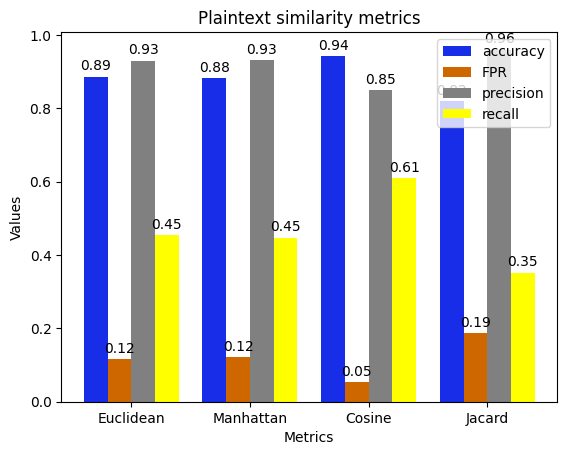

In [ ]:
plot_bar_graph_multi(metrics_df.T,title="Plaintext similarity metrics")

In [ ]:
relu_metrics_df = calculate_sim_measures(df,"relu features",euc_threshold=0.9,
                                    man_threshold=35,jac_threshold=0.4)
relu_metrics_df

,Euclidean,Manhattan,Cosine,Jacard
accuracy,0.960600,0.916700,0.919300,0.954350
FPR,0.030474,0.081053,0.079579,0.039053
precision,0.791000,0.874000,0.898000,0.829000
recall,0.695464,0.545801,0.534509,0.660106


<Figure size 2000x600 with 0 Axes>

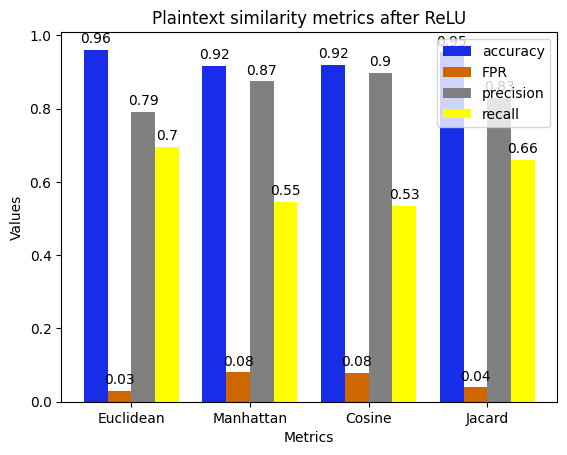

In [ ]:
plot_bar_graph_multi(relu_metrics_df.T,title="Plaintext similarity metrics after ReLU")

## Section 2 Encrypted similarity

This section of the notebook is dedicated to replicating the protocol used in the paper which will be as follows
1. Feature extraction
2. SMC encryption
3. Propsed protocol
4.  Conventional similarity measures under SMC



### 2.1. Feature extraction or in the authors' words:
>Upon receiving the images, the proxy server first extracts the
image feature vectors. An image feature vector is generally an
abstraction of an image which is used to characterize and quantify the image content. The proposed framework considers two
types of image vectors i.e. handcrafted vectors and high level features.

The propsed algorithm works as follows:
**Algorithm 1**: Feature extraction and  encryption

**Input:** Image I, Feature vectors 𝐹ᵥ

**Output:** Encrypted feature 𝐹ᵥ'
```
fᵥᵢ ← Feature_Extract(Iᵢ)
for i in fᵥᵢ,fᵥⱼ do

    S ← D(fᵥᵢ-fᵥⱼ)
    F ← S.append
end
for i in F do

    fᵥ'=SMC_Encrypt(Fᵢ)

end

```

**Note:** Since the features are already extracted. The algorithm will be used for ubtraction only

### 2.2. SMC Encryption
>Though the conventional secure image retrieval system encrypts the outsourced image, image features are stored in a
plaintext form which opens to security vulnerable attacks. By
analysing these features, the intruder will try to derive the input
images. To ensure the privacy of the features under distributed
environment, the proposed system uses secure additive secret
sharing with the help of a secure multiparty computation protocol for sharing the secret image features.

**Algorithm 2:** SMC_Encrypt()

**Input:** F, Keys Kᵢ, random variable aᵢ

**Output:** 𝐹ᵥ'

```
Function Gen_share(F)
for i in F Do

    if (Fᵢ mod2 ==0) Then

        Assign shareF1 ← 1
        F2 = Fᵢ-shareF1
        shareF2 ← int(F2/2)
        shareF3 ← Fᵢ-shareF2
    
    else
        Assign shareF1 ← 2
        F2 = Fᵢ-shareF1
        shareF2 ← int(F2/2)
        shareF3 ← Fᵢ-shareF2
    end
end

while ≤ n Do
    Choose Kᵢ
    Share Kᵢ to i+1 entity
    choose aᵢ ∈ ℤ2ⁿ
end

A:
secret_F1 = shareF1+k1-k3+a1
B:
secret_F2 = shareF2+k2-k1+a2
C:
secret_F3 = shareF3+k3-k2+a3
fᵥ' = secret_F1+secret_F2+secret_F3

```



        





1. Read aobut SMC and present and homomorphic encrpytion
2. Do a report of your work so far
The added random number, the lost values in truncating

In [ ]:
class party:
    """
    A party for a secure multiparty computation
    """
    def __init__(self,public_key:int,shared_key:int,private_key:int) -> None:
        """
        Args:
            public_key (int): the public key of the entity that it shares with the entity next to it
            share_key (int): the key that is shared from another entity
            private_key(int): the key that it keeps private
        """
        self.public_key=public_key
        self.shared_key=shared_key
        self.private_key=private_key

    def encrypt(self,vector:np.ndarray)-> np.ndarray:
        """
        encrypts the input vector according to this formula
        encrypted_vector = vector+self.public_key-self.shared_key+self.private_key

        Args:
            vector a numpy array of feature vectors

        Returns:
            a numpy array of the encrypted vector
        """

        return vector+self.public_key-self.shared_key+self.private_key


class SMC_protocol:
    """
    A full simulation of the proposed encryption protocol in the article
    where it encrypts by using three entities then it tries to fetch similar images
    based on the proposed algorithm
    """

    def __init__(self,num_entities=3)->None:
        """
        Args:
            num_entities: optional the number of entities that are used by the protocol
        """
        k=np.random.randint(10**8,size=num_entities)
        a=2**np.random.randint(10**2,size=num_entities)
        self.entities= [party(k[i],k[i-1],a[i]) for i in range(num_entities) ]


    def gen_share(self,f):
        """
        As in the article this function goes through every element of the feature vector and if the element
        is divisible by two it assigns the shareF1 as 1 otherwise it sets it to 2 and then calculates F2,shareF2 ,
        and shareF3 according to these formulas:
        F2 = Fi -shareF  1
        shareF2 = int(F2/2)
        shareF3 = Fi - shareF2
        Args :
            feature_vector a numpy array of size (1,x) x depends on the used feature extractor
        Returns
            a numpy array of size (x,3)
        """

        share_f1 = np.where(np.round(f) % 2 == 0, 1, 2)
        f2 = f - share_f1
        share_f2 = (f2 / 2).astype(np.int32)
        share_f3 = f - share_f2

        return np.row_stack((share_f1, share_f2, share_f3))


    def feature_extraction(self,im, model=None):
        """
        Extract the features from a given image and subtract each element from
        all the other elements, then take only the upper triangle from the resulting
        matrix changing the shape of the extracted vector from n to n*(n-1)/2.

        Args:
            im: a numpy array of the image
            model: a feature extractor

        Returns: extracted vector
        """
        if model is not None:
            features = model(im).astype(np.float32)  # Use a more memory-efficient data type
        else:
            features = im.astype(np.float32)  # Use a more memory-efficient data type



        # Create 2D array with all possible combinations of subtractions
        res = features[:, np.newaxis] - features


        # Flatten the upper triangular part of the 2D array

        return res[np.triu_indices(len(features), k=1)]



    def smc_encrypt(self,feature_vector:np.ndarray)->np.ndarray:
        """
        Encrypts the given vector by generating the shared values then sending
        every row of its rows to a different entity

        Args:
            feature_vector: the extracted feature vector after it has passed through the
            gen_share function i.e. of size(n,m) where n has to be the same as the number
            of entities

        Returns:
            a numpy array of shape(m) where the results of the entities are added
        """
        feature_vector=self.feature_extraction(feature_vector)
        feature_vector_shares = self.gen_share(feature_vector)

        res=np.zeros(feature_vector_shares.shape[1])
        for i,entity in enumerate(self.entities):
            res+=entity.encrypt(feature_vector_shares[i,:])

        return res

In [ ]:
from sklearn.decomposition import MiniBatchSparsePCA

n_components = 1024
batch_size = 16


spca = MiniBatchSparsePCA(n_components=n_components,  batch_size=batch_size)

feature_vectors = np.asarray([np.asarray(feature) for feature in df["relu features"]])

spca.fit(feature_vectors)
X_features=spca.transform(feature_vectors)

# Calculate the explained variance manually
components = spca.components_
total_variance = np.sum(np.var(feature_vectors, axis=0))
explained_variance = np.sum(np.var(feature_vectors @ components.T, axis=0))
explained_variance_ratio = explained_variance / total_variance

print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: 1.8685234749203607


In [ ]:
df["new features"]=X_features.tolist()

spca_metrics_df = calculate_sim_measures(df,"new features",euc_threshold=0.9,
                                    man_threshold=25,jac_threshold=0.4)
spca_metrics_df

,Euclidean,Manhattan,Cosine,Jacard
accuracy,0.968750,0.962450,0.971250,0.969400
FPR,0.003105,0.023632,0.005632,0.003632
precision,0.434000,0.698000,0.532000,0.457000
recall,0.914543,0.718522,0.885053,0.908729


<Figure size 2000x600 with 0 Axes>

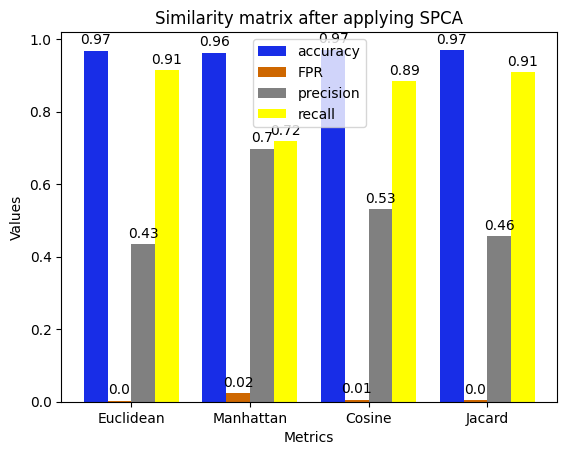

In [ ]:
plot_bar_graph_multi(spca_metrics_df.T,title="Similarity matrix after applying SPCA")

In [ ]:
import os
import multiprocessing

num_processes = os.cpu_count()
protocol=SMC_protocol()

with multiprocessing.Pool(processes=num_processes) as pool:
    # Create and fit the model within each process
    X_encrypted =pool.map(protocol.smc_encrypt,X_features)

df["encrypted"]=X_encrypted
df.head()

,idx,features,relu features,new features,encrypted
0,0,"[-0.764498233795166, 0.2703744173049927, -0.57...","[0.0, 0.2703744173049927, 0.0, 0.0, 0.0, 0.0, ...","[-0.9928001811483388, -0.2817320795751782, -0....","[3.288931906223297, 3.0805561542510986, 1.4545..."
1,0,"[-0.7869440913200378, -0.14904724061489105, -1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.7211871231004314, -0.3963240142573641, -0....","[2.6751368939876556, 3.4205145835876465, 2.843..."
2,0,"[-0.6767528057098389, 0.3972959518432617, -1.1...","[0.0, 0.3972959518432617, 0.0, 0.0, 0.0, 0.0, ...","[-1.0801729389932826, 0.09836845501112125, 0.2...","[2.8214586973190308, 2.6417940855026245, 2.585..."
3,0,"[-0.3759235143661499, 0.4669526219367981, -1.3...","[0.0, 0.4669526219367981, 0.0, 0.0, 0.0, 0.0, ...","[-0.3898394119480536, -0.4670162733150144, 0.1...","[3.077176868915558, 3.4970489740371704, 2.7939..."
4,0,"[-1.0289041996002197, 0.1245494931936264, -1.1...","[0.0, 0.1245494931936264, 0.0, 0.0, 0.0, 0.0, ...","[-0.9753140628249928, -0.24120076385337716, -0...","[3.265886664390564, 3.0534998178482056, 1.4338..."


In [ ]:
save_to_drive=True #@param{type:"boolean"}
if save_to_drive:
    df.to_csv("inira_holiday_encrypted_final.csv",index=False)
    !cp /content/inira_holiday_encrypted_final.csv /content/drive/MyDrive/

### 2.3 Proposed protocol

>Secure multiparty based similarity matching function, SESIM is the fundamental protocol for the proposed secure similar image search scheme. The similarity between two encrypted feature vectors can be obtained by performing encrypted division operation with a multi-party environment. The absolute value of the similarity matching is calculated with respect to the similarity threshold value. The proposed similarity matching expression is formulated as below:
>Let SMC_Encrypt be the proposed encryption function of
secret sharing, a and K be the secret shared key and the encrypted values of query and image feature vectors qfv and fv
are given by,
qfv = SMC_Encrypt(qfv, a, K) (7)
fv = SMC_Encrypt(fv, a, K) (8)
Sim_score is the similarity computation function of two encrypted vectors qfv
,fv and are expressed as,
Sim_score = Enc_Division(qfv,fv) (9)
Then the similarity result among the vectors will be,
Result is Similar; 0.8 ≤ Sim−score ≤ 1.2
Dissimilar; otherwise


**Alogrithm 3:** Proposed SESIM scheme

**Input:** Query features qfv, fv' Threshold

**Output:** Sim_images(I1,I2....,In)
```
Initialize Arry I
qfv' = SMC_Encrypt(qfv,k,a)

Function Enc_Divison(qfv',fv')
for i in qfv',fv' do
    Resi =⌊qfvi'÷fvi'⌋
end
return Res

Function Sim_match(qfv',fv')
sim_score=Enc_Division(qfv,fv')mod 100
if (sim_score < 0.8) then
    Feature.skip_fv'
else if (sim_score > 1.2) then
    Feature.overfit.skip_fv'
else
    I.append_fv'
end
Return sim_images I1,I2.....,In
```
**Note:** Since the data is already encrypted this notebook won't encrypt anything agian

In [ ]:
from typing import List,Dict
from timeit import default_timer

def enc_division(encrypted_query,encrypted_vectors:List[np.ndarray],method="mean",threshold=0.2)->List[float]:
    """
    This function returns a similarity score between two encrypted vectors
    it firstly encrypts the query image that is provided in the constructor and compares it with the
    provided list of encrypted vectors according to the following formula
    Res = np.sum(np.floor(query_vector_enc/feature_vector))

    Args :
        encrypted_query: a numpy array the query vector
        encrypted_vectors a list of all the encrypted vectors in the database

    Returns :
    Try Median then mean
    try voting
        a similarity score with the encrypted vectors
    """
    sim_match = []
    if method=="mean":
        for encrypted_vector in encrypted_vectors:

            sim_match.append(np.mean(np.floor(encrypted_query/encrypted_vector)))
    elif method=="median":
        for encrypted_vector in encrypted_vectors:

            sim_match.append(np.median(np.floor(encrypted_query/encrypted_vector)))
    elif method == "voting":
        # Fix: Calculate the number of elements satisfying the condition instead of the ratio itself
        for encrypted_vector in encrypted_vectors:
            vote_mask = ((encrypted_query / encrypted_vector) > (1 - threshold)) & ((encrypted_query / encrypted_vector) < (1 + threshold))

            num_votes = np.sum(vote_mask)
            if num_votes > len(vote_mask) / 2:
                sim_match.append(True)  # Vote for this vector
            else:
                sim_match.append(False)  # Don't vote for this vector
    else:
        raise ValueError(f"unrecognized type {method} Plaese chose one of 'mean','median','voting'")



    return sim_match

def sim_match(encrypted_query:np.ndarray,encrypted_vectors:List[np.ndarray],
              method="mean",threshold=0.2)->np.ndarray:
    """
    This function implements the similarity matching that is proposed in the article
    wherein it compares the enc_distance and if the sim match is between [0.8,1.2]
    inclusive

    Args:
        encrypted_vectors: The encrypted vectors in the database
        names: The first name of the users

    Returns:
        The first name of the match
    """
    if method=="voting":
      return np.asarray(enc_division(encrypted_query,encrypted_vectors,method))
    a = enc_division(encrypted_query,encrypted_vectors,method)
    sim_matches=[match%100 for match in a]
    for i in range(len(sim_matches)) :
        sim_matches[i]=sim_matches[i]>1-threshold and sim_matches[i]<1+threshold
    sim_matches = np.asarray(sim_matches)
    return sim_matches

def sesim_measure(df:pd.DataFrame,method="mean")->Dict[str,float]:
    """
    Calculates the metrics using the propsed sesim measures

    Args:
        df: a pandas DataFrame hvaing an encypted feature vector as a column
        and and idx column

    Returns:
        a dictonary where the metrics are the keys and the corresponding values
        of the metrics are the values of teh dictonary
    """

    encrypted_vectors = [np.asarray(vector) for vector in df["encrypted"]]
    encrypted_vectors=np.asarray(encrypted_vectors)
    sesim_acc=[]
    sesim_fpr=[]
    sesim_precision=[]
    sesim_recall=[]
    time=[]
    for i in range(len(df)):
        start=default_timer()
        ground_truth=np.array(df["idx"]==df.loc[i]["idx"])
        score=sim_match(np.asarray(df.loc[i]["encrypted"]),encrypted_vectors,method)
        acc,fpr,precision,recall=calculate_metrics(score,ground_truth)
        end=default_timer()
        time.append(end-start)
        sesim_acc.append(acc)
        sesim_fpr.append(fpr)
        sesim_precision.append(precision)
        sesim_recall.append(recall)

    no_retrevial =np.count_nonzero(np.asarray(recall)==0)

    sesim_metrics={"accuracy":np.mean(np.asarray(sesim_acc)),
                   "FPR":np.mean(np.asarray(sesim_fpr)),
                   "precision":np.mean(np.asarray(sesim_precision)),
                   "recall":np.mean(np.asarray(sesim_recall))}

    time_metrics={"average time":np.mean(np.asarray(time)),
                  "total time (minutes)":np.sum(np.asarray(time))/60}

    print(f"Number of non retrevial is:{no_retrevial}")
    print(f"With a precentage of:{no_retrevial/len(df)}")
    return sesim_metrics,time_metrics


In [ ]:
sesim_metrics,time_metrics=sesim_measure(df)
sesim_metrics,time_metrics

Number of non retrevial is:0
With a precentage of:0.0


({'accuracy': 0.9545,
  'FPR': 0.0005263157894736842,
  'precision': 0.1,
  'recall': 0.95},
 {'average time': 0.3101882010350346,
  'total time (minutes)': 1.0339606701167818})

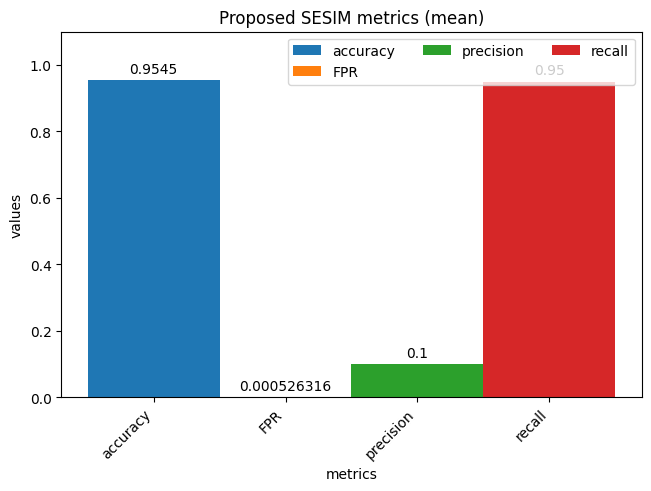

In [ ]:
plot_bar_graph(sesim_metrics,title='Proposed SESIM metrics (mean)')

In [ ]:
med_metrics,med_time_metrics=sesim_measure(df,"median")
med_metrics,med_time_metrics

Number of non retrevial is:0
With a precentage of:0.0


({'accuracy': 0.5278,
  'FPR': 0.4720263157894736,
  'precision': 0.5245000000000001,
  'recall': 0.08772395010750915},
 {'average time': 1.5448910140600036,
  'total time (minutes)': 5.149636713533345})

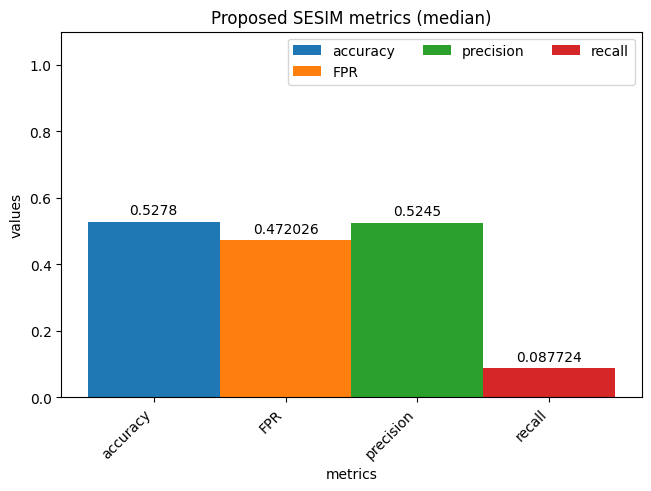

In [ ]:
plot_bar_graph(med_metrics,title='Proposed SESIM metrics (median)')

In [ ]:
voting_metrics,voting_time_metrics = sesim_measure(df,"voting")
voting_metrics,voting_time_metrics

Number of non retrevial is:0
With a precentage of:0.0


({'accuracy': 0.05, 'FPR': 1.0, 'precision': 1.0, 'recall': 0.05},
 {'average time': 0.578439319150018,
  'total time (minutes)': 1.9281310638333935})

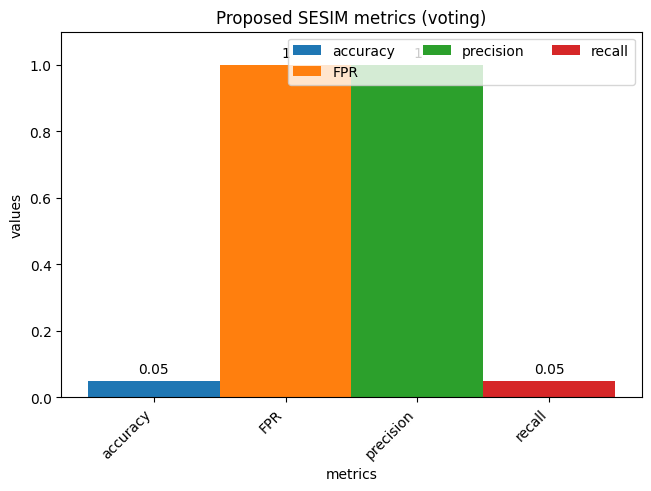

In [ ]:
plot_bar_graph(voting_metrics,title='Proposed SESIM metrics (voting)')

### 2.4 Conventional similarity measures under SMC


This section tries to compare between the accuracy of the propsed encryption scheme and its un-encrypted counterparts by using the same metrics  


In [ ]:
complete_seesion=False #@param{type:"boolean"}
if complete_seesion:
    import ast
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv("/content/drive/MyDrive/inira_holiday_encrypted.csv",converters={'encrypted': ast.literal_eval})
    df.head()


In [ ]:
enc_metrics_df=calculate_sim_measures(df,"encrypted",normalize=False,
                                      euc_threshold=1.5,man_threshold=10)
enc_metrics_df

,Euclidean,Manhattan,Cosine,Jacard
accuracy,0.954350,0.954350,0.05,0.05
FPR,0.000684,0.000684,1.00,1.00
precision,0.100000,0.100000,1.00,1.00
recall,0.935000,0.935000,0.05,0.05


<Figure size 2000x600 with 0 Axes>

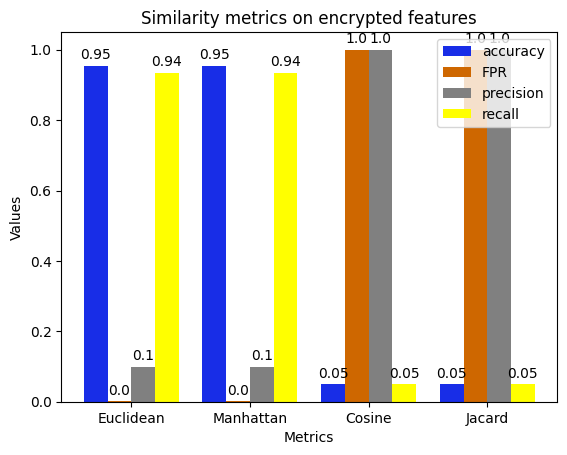

In [ ]:
plot_bar_graph_multi(enc_metrics_df.T,title="Similarity metrics on encrypted features")

**Note:**When the metrics have the following values

Accuracy 0.05

FPR 1

Precision 1

Recall 0.05

it means that the model is retreiving all the images in whcih case you should try decreasing the threshold value of the Euclidean and Manhattan measures and increasing the values of the Jaccard and Cosine measures

In [ ]:
enc_euc_metrics,enc_euc_time_metrics=calculate_sim_one(df,"encrypted","euclidean",1.5,normalize=False)
enc_euc_metrics,enc_euc_time_metrics

({'accuracy': 0.05, 'FPR': 1.0, 'precision': 1.0, 'recall': 0.05},
 {'Total time in minutes': 4.91973918408324,
  'Average time': 1.475921755224972})

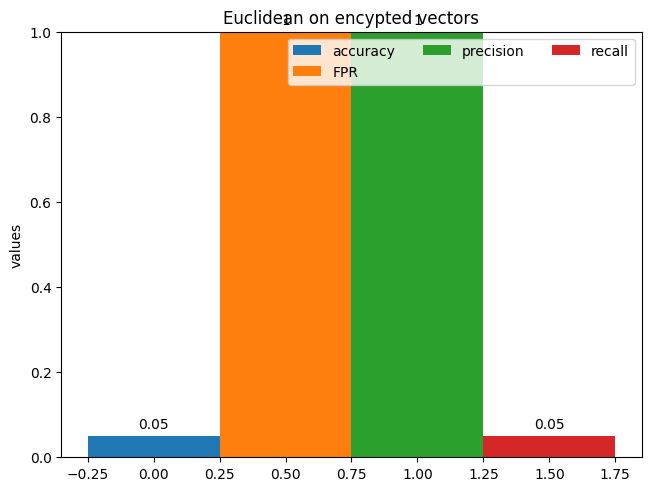

In [ ]:
plot_bar_graph(enc_euc_metrics,"Euclidean on encypted vectors")

In [ ]:
man_sim_metrics,man_time_metrics=calculate_sim_one(df,"encrypted","manhattan",10,normalize=False)
man_sim_metrics,man_time_metrics

({'accuracy': 0.95435,
  'FPR': 0.0006842105263157893,
  'precision': 0.1,
  'recall': 0.935},
 {'Total time in minutes': 2.7555048264335102,
  'Average time': 0.8266514479300531})

In [ ]:
cosine_sim_metrics,cosine_time_metrics=calculate_sim_one(df,"encrypted","cosine",1.001)
cosine_sim_metrics,cosine_time_metrics

({'accuracy': 0.05, 'FPR': 1.0, 'precision': 1.0, 'recall': 0.05},
 {'Total time in minutes': 1.8873238309334586,
  'Average time': 0.5661971492800376})

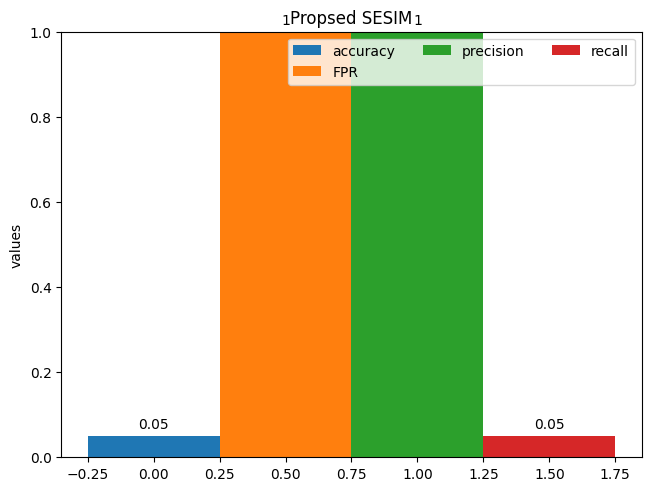

In [ ]:
plot_bar_graph(cosine_sim_metrics)

In [ ]:
jac_sim_metrics,jac_time_metrics=calculate_sim_one(df,"encrypted","jaccard",0.999)
jac_sim_metrics,jac_time_metrics

({'accuracy': 0.95435,
  'FPR': 0.0006842105263157893,
  'precision': 0.1,
  'recall': 0.935},
 {'Total time in minutes': 2.1490194171169907,
  'Average time': 0.6447058251350972})

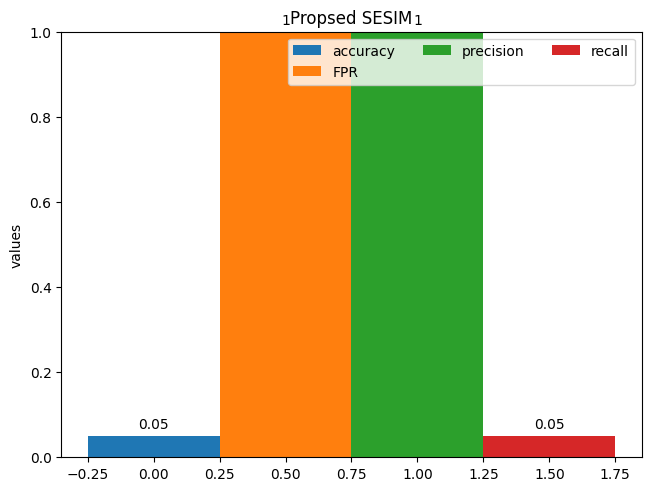

In [ ]:
plot_bar_graph(jac_sim_metrics)

## Section 3: Plaintext similarity using low level features

In [ ]:
#re-downloading the data since the notebook is being run over multiple days
complete_session = True#@param{type:"boolean"}
if complete_session:
    from pathlib import Path
    data_path=Path.cwd()
    new_pth = data_path/"holiday"
    if new_pth.exists():
        print("Data is already downloaded")

    else :
        from google.colab import files
        uploaded = files.upload()
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !rm -rf kaggle.json
        !kaggle datasets download -d rasvanjaya21/inria-holidays-dataset
        !unzip inria-holidays-dataset.zip -d holiday
        !rm -rf inria-holidays-dataset.zip

Saving kaggle.json to kaggle.json
 98% 346M/352M [00:04<00:00, 78.5MB/s]
100% 352M/352M [00:04<00:00, 78.6MB/s]
Archive:  inria-holidays-dataset.zip
  inflating: holiday/buah/138300.jpg  
  inflating: holiday/buah/138301.jpg  
  inflating: holiday/buah/138302.jpg  
  inflating: holiday/buah/138303.jpg  
  inflating: holiday/buah/138304.jpg  
  inflating: holiday/buah/138305.jpg  
  inflating: holiday/buah/138306.jpg  
  inflating: holiday/buah/138307.jpg  
  inflating: holiday/buah/138308.jpg  
  inflating: holiday/buah/138309.jpg  
  inflating: holiday/bunga/136000.jpg  
  inflating: holiday/bunga/136001.jpg  
  inflating: holiday/bunga/136002.jpg  
  inflating: holiday/bunga/136003.jpg  
  inflating: holiday/bunga/136004.jpg  
  inflating: holiday/bunga/136007.jpg  
  inflating: holiday/bunga/136008.jpg  
  inflating: holiday/bunga/136009.jpg  
  inflating: holiday/bunga/136010.jpg  
  inflating: holiday/bunga/141900.jpg  
  inflating: holiday/fajar/126401.jpg  
  inflating: holiday/

### 3.1 Getting the data and setting it up

In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from pathlib import Path
data_path=Path.cwd()
new_pth = data_path/"holiday"
if new_pth.exists():
    print("Data is already downloaded")


imgs_lst= list(new_pth.glob("*/*.jpg"))
imgs_class = [str(name).split("/")[-2] for name in imgs_lst]


Data is already downloaded


### 3.2 Extracting the features

In [ ]:
from timeit import default_timer
REQUIRED_SIZE=(1024,1024)# Same shape as VGG-16 input
tic=default_timer()
features=[]
for img_pth in imgs_lst:
    img=imread(img_pth)
    resized_img =resize(img,REQUIRED_SIZE)
    fd= hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2),channel_axis=2,feature_vector=True)
    features.append(fd.tolist())

tac=default_timer()
print(tac-tic)


409.6852532089997


In [ ]:
value_to_idx={}
idx=[]
for value in imgs_class:
    # Check if the value is already in the dictionary
    if value not in value_to_idx:
        # If not, add it with a new index
        value_to_idx[value] = len(value_to_idx)
    # Append the index to the encoded list
    idx.append(value_to_idx[value])
low_df= pd.DataFrame({"Name":imgs_class,"idx":idx,"features":features})
low_df.head()

,Name,idx,features
0,rumah,0,"[0.15138673092380986, 0.03489913417422549, 0.0..."
1,rumah,0,"[0.14489177315710797, 0.29222341016636616, 0.2..."
2,rumah,0,"[0.3779652170854914, 0.021175533540781152, 0.0..."
3,rumah,0,"[0.28200513326569576, 0.023012807802862537, 0...."
4,rumah,0,"[0.0956699583606905, 0.0, 0.15332371522481936,..."


In [ ]:
low_df.to_csv("inira_holiday_encrypted_low.csv",index=False)
save_to_drive=False#@param{type:"boolean"}
if save_to_drive:
    !cp /content/inira_holiday_encrypted_low.csv /content/drive/MyDrive/

In [ ]:
complete_session =False #@param{type:"boolean"}
if complete_session:
    low_df=pd.read_csv("/content/drive/MyDrive/encrypted_low_features.csv",converters={'features': ast.literal_eval,
                                                                                      'encrypted':ast.literal_eval,})

### 3.3 Calculating the metrics

In [ ]:
len(fd)

580644

In [ ]:
low_metrics_df=calculate_sim_measures(low_df,"features")
low_metrics_df

,Euclidean,Manhattan,Cosine,Jacard
accuracy,0.05,0.954350,0.050000,0.05
FPR,1.00,0.000684,0.999842,1.00
precision,1.00,0.100000,0.997000,1.00
recall,0.05,0.935000,0.049863,0.05


In [ ]:
euc_low_metrics,euc_low_time=calculate_sim_one(low_df,"features","euclidean",0.8,normalize=False)
euc_low_metrics,euc_low_time

({'accuracy': 0.31585,
  'FPR': 0.7099473684210525,
  'precision': 0.8059999999999999,
  'recall': 0.08600477461814815},
 {'Total time in minutes': 5.102305957349866,
  'Average time': 1.53069178720496})

<Figure size 2000x600 with 0 Axes>

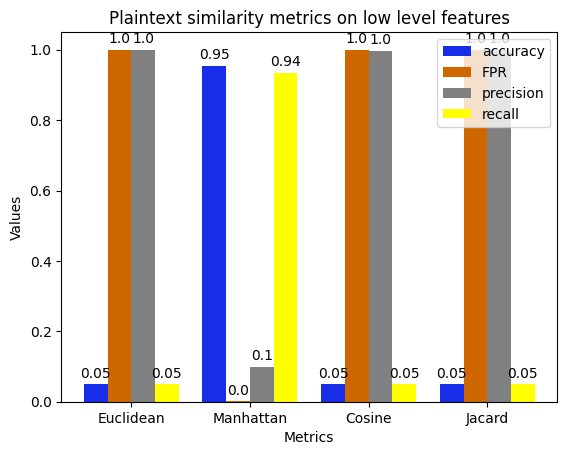

In [ ]:
plot_bar_graph_multi(low_metrics_df.T,"Plaintext similarity metrics on low level features")

## Section 4: Propsed scheme on low level features

This section will encrypt the feature vectors just as in section 2 and it will use the same metric the only diffence is that features here are low level

### 4.1 Feature encryption

In [ ]:
low_df["encrypted"] = low_df["features"].apply(lambda x: encrypt(np.asarray(x)).tolist())
low_df.head()

In [ ]:
import os
import multiprocessing
features=[np.asarray(feature) for feature in low_df["features"]]
protocol=SMC_protocol()

with multiprocessing.Pool(processes=num_processes) as pool:
    # Create and fit the model within each process
    encrypted_features =pool.map(protocol.smc_encrypt,features)



low_df["encrypted"]=encrypted_features

### 4.2 Calculting the propsed SESIM similarity socre and evaluating the metrics

In [ ]:
sesim_metrics_low=sesim_measure(low_df)
sesim_metrics_low

In [ ]:
plot_bar_graph(sesim_metrics_low,"Propsed SESIM on low level features")

### 4.2 Calculting the other similarit measures socre and evaluating the metrics

In [ ]:
enc_low_metrics_df=calculate_sim_measures(low_df,"encrypted")
enc_low_metrics_df

In [ ]:
plot_bar_graph_multi(enc_low_metrics_df,
                     title="Plaintext similarity metrics on encrypted low level features")

In [ ]:
save_to_drive=False#@param{type:"boolean"}
if save_to_drive:
    low_df.to_csv("encrypted_low_features.csv",index=False)
    !cp /content/encrypted_low_features.csv /content/drive/MyDrive/